In [100]:
import pathlib
import shutil
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

In [146]:
# Functions for tag and category manipulation

def get_tag_set(tag):
    s = set(tag.split('-'))
    s.discard('')
    return s

def superset(subsets):
    return set.union(*subsets)
    
def one_to_many(df, from_col = 'category_set', to_col = 'category'):
    # distributes a single snippet (row), with multiple assigned tags/categories, to multiple rows,
    # one with each each individual tag/category in the to_col entry.
    
    dfs = []
    # get all the unique category/tag values
    unique = superset(df[from_col].values)
    for u in unique:
        # create a new dataframe with index of the single unique category/tag, and values of all the rows
        # of the original dataframe where the set in the from_col contains that unique category/tag
        # append it to a list
        dfs.append(pd.concat({u: df.loc[df[from_col].apply(lambda x: u in x), :]}, names=[to_col]))
    # join them all together, and reset the index so the single category is a column
    return pd.concat(dfs).droplevel(1).reset_index()

def many_to_one(df):
    # reverses the one to many operation, keeping one row per unique snippet.
    # assumes the useful 'category_set' column still exists
    return df.groupby(['filename','package_hash']).first().reset_index().drop('category', axis=1)

def supports(df, on_col='category'):
    return df.groupby(on_col).size()

def copy_to_new_package(df, destination_root):
    [(destination_root/x).mkdir() for x in df.groupby('package_hash').groups.keys()]
    
    df.apply(lambda x: shutil.copy(data_root/x['package_hash']/x['filename'], destination_root/x['package_hash']/x['filename']), axis=1)
    
    df.to_csv(destination_root/'01_manifest.csv', index=False)
    df.to_pickle(destination_root/'01_manifest.pkl')

In [4]:
# Functions for listen functionality

feature_settings = {'fmax': 8000, 'power': 2, 'n_mels' :64, 'n_fft':2048, 'hop_length':1024}

def get_features(filepath='', data=[], fs=-1):
    if filepath:
        data, fs = sf.read(filepath)
    else:
        assert (len(data>0) and fs >0), 'Must provide either a filename, or array of data and sample rate'
    
    S = librosa.feature.melspectrogram(y=data, 
                                   sr = fs, **feature_settings)
    return S, fs
    
def plot_features(filepath='', data=[], fs=-1):

    features, fs = get_features(filepath, data, fs)
    
    plt.figure()
    librosa.display.specshow(librosa.power_to_db(features),y_axis='mel',x_axis='time',fmax = feature_settings['fmax'], hop_length = feature_settings['hop_length'], sr=fs)
    plt.show()

def change_gain(data, gain):
    data *= gain
    return data.clip(-1.0, 1.0)

def listen_to_snippet(snippet, gain, **kwargs):
    _input = 'r'
    
    data, fs = sf.read(snippet)

    data = change_gain(data, gain)

    if kwargs.get('plot',True):
        plot_features(data=data, fs=fs) #this makes the tagging process sluggish
    
    
    while _input == 'r':  # replay tag
        ipd.display(ipd.Audio(data, rate=fs, autoplay=True))
        ipd.set_matplotlib_close(close=True)
        _input = input()
        if _input.startswith('volume'):
            try:
                old_gain = gain
                gain = float(_input.split('=')[1]) / 100.0
                data = change_gain(data, gain)
                print('Gain set to {}'.format(gain))
            except:
                print(
                    'Volume could not be set! Enter "volume=100" (normal), "volume=200" (Louder), "volume=800" (Even Louder), "volume=50" (Quieter) etc')
            else:
                _input = 'r'
    
    return _input, gain


def listen_to_snippets(df, data_root, *args, **kwargs):
    """
    kwargs
        random: shuffle rows of the dataframe
        n: total number of snippets to listen to 
        plot: plot a spectrogram
    """
    subset = df
    gain = 1.0
    
    # shuffle or not
    if kwargs.pop('random',True):
        subset = subset.sample(frac=1)
    
    for i,row in subset.iloc[:kwargs.pop('n',None)].iterrows():
        print(row)
        file = data_root/row['package_hash']/row['filename']
        print(file)
        try:
            _input, gain = listen_to_snippet(file, gain, **kwargs)
            if _input =='q':
                break
        except Exception as e:
            print('Error Listening to {}, with error: {}'.format(file, e))


In [139]:
# categorisation utilities
category_mapping = {" do": "animal_dogs","a": "indeterminate","ae": "","at": "human_voice","b": "background","ba": "background","baa": "background","bar": "background","bbi": "animal_birds","bca": "background","bcr": "background","be": "signals_bell","bi": "animal_birds","bia": "animal_birds","bib": "animal_birds","bir": "animal_birds","bme": "mechanical","bs": "mechanical_construction","bwi": "nature_wind","bz": "digital_distortion","c": "transport_car","ca": "transport_car","ccr": "animal_insects","ce": "animal_insects","cer": "animal_insects","ch": "animal_poultry","ck": "animal_cockatoo","cl": "digital_distortion","cme": "mechanical","cr": "animal_insects","cre": "animal_insects","ct": "animal_crow","cw": "animal_other","cz": "human_movement","db": "indeterminate","dg": "animal_dogs","didi": "digital_distortion","dl": "human_movement","do": "animal_dogs","dob": "animal_dogs","doi": "animal_dogs","don": "animal_dogs","dor": "animal_dogs","ds": "human_movement","du": "animal_poultry","f": "","fr": "animal_other","ft": "human_movement","ga": "animal_birds","ge": "animal_other","go": "indeterminate","gr": "mechanical_construction","ha": "mechanical_construction","he": "transport_aircraft","ho": "signals_horn","hu": "human_movement","i": "mechanical_impulsive","im": "mechanical_impulsive","in": "indeterminate","is": "animal_insects","lo": "indeterminate","ls": "","m": "mechanical","ma": "mechanical","Mar": "mechanical","me": "mechanical","mec": "mechanical","meow": "animal_other","mer": "mechanical","mi": "signals_tone","mo": "transport_motorcycle","mp": "indeterminate","mr": "mechanical","mu": "music","mw": "mechanical","na": "nature_rain","ne": "mechanical","nu": "music","o": "animal_dogs","ol": "transport_aircraft","pf": "human_movement","ph": "signals_bell","pl": "transport_aircraft","ps": "human_movement","R": "","r": "","r'": "","ra": "nature_rain","ro": "animal_poultry","sh": "animal_other","si": "signals_siren","sp": "mechanical_construction","t": "human_voice","ta": "human_voice","tar": "human_voice","tdoa": "human_voice","tf": "human_movement","th": "mechanical_impulsive","tl": "signals_bell","tr": "transport_train","va": "mechanical_construction","w": "nature_wind","we": "mechanical_construction","wef": "mechanical_construction","wf": "mechanical_construction","wh": "signals_bell","wi": "nature_wind","wib": "nature_wind","wo": "mechanical_construction","ya": "","air_conditioner": "mechanical","car_horn": "signals_horn","children_playing": "human_voice","dog_bark": "animal_dogs","drilling": "mechanical_construction","engine_idling": "transport_car","gun_shot": "mechanical_impulsive","jackhammer": "mechanical_construction","siren": "signals_siren","street_music": "music", "#NAME?": ""}

final_categories = ["animal_dogs", "animal_insects", "animal_birds", "animal_cockatoo", "animal_poultry",  "background","human_voice",  "indeterminate","mechanical", "mechanical_construction", "mechanical_impulsive","nature_wind", "signals_horn", "signals_siren", "transport_car"]

from sklearn.preprocessing import MultiLabelBinarizer

category_encoder = MultiLabelBinarizer().fit([final_categories])

In [46]:
# set your path here
data_root = pathlib.Path('/Volumes/Clavius/documents/Documents/Employment/NoiseNet/Development/tag_data/processed/')
manifest_path = data_root/'02_manifest.csv'

# read the manifest in
manifest = pd.read_csv(manifest_path)
manifest.head()

,filename,package_hash,manual_tag
0,2019-02-19 19_39_18.wav,635_cnnmodel_20190220_verification_package,ba-do
1,2019-02-06 13_14_24.wav,635_cnnmodel_20190220_verification_package,ta-do
2,2019-02-19 19_46_53.wav,635_cnnmodel_20190220_verification_package,ba-do
3,2019-02-17 19_23_04.wav,635_cnnmodel_20190220_verification_package,cr-do
4,2019-02-19 19_03_00.wav,635_cnnmodel_20190220_verification_package,wi-ba


In [47]:
# assign a set of tags to each row
manifest['tag_set'] = manifest['manual_tag'].apply(get_tag_set)
# from these individual tags, perform the lookup and assign the set of categories
manifest['category_set'] = manifest['tag_set'].apply(lambda x: {category_mapping[t] for t in x})
manifest.head()

,filename,package_hash,manual_tag,tag_set,category_set
0,2019-02-19 19_39_18.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
1,2019-02-06 13_14_24.wav,635_cnnmodel_20190220_verification_package,ta-do,"{ta, do}","{animal_dogs, human_voice}"
2,2019-02-19 19_46_53.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
3,2019-02-17 19_23_04.wav,635_cnnmodel_20190220_verification_package,cr-do,"{cr, do}","{animal_dogs, animal_insects}"
4,2019-02-19 19_03_00.wav,635_cnnmodel_20190220_verification_package,wi-ba,"{ba, wi}","{nature_wind, background}"


In [66]:
# Perform the one-to-many assignment to flatten category set into individual categories
# each row (snippet) may appear more than once in the categorised dataframe, once for each category of noise 
# that was tagged in the snippet
categorised = one_to_many(manifest, from_col='category_set', to_col='category')
categorised_reduced = categorised[categorised['category'].apply(lambda x: x in final_categories)]
categorised_reduced

,category,filename,package_hash,manual_tag,tag_set,category_set
47,animal_dogs,2019-02-19 19_39_18.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
48,animal_dogs,2019-02-06 13_14_24.wav,635_cnnmodel_20190220_verification_package,ta-do,"{ta, do}","{animal_dogs, human_voice}"
49,animal_dogs,2019-02-19 19_46_53.wav,635_cnnmodel_20190220_verification_package,ba-do,"{ba, do}","{animal_dogs, background}"
50,animal_dogs,2019-02-17 19_23_04.wav,635_cnnmodel_20190220_verification_package,cr-do,"{cr, do}","{animal_dogs, animal_insects}"
51,animal_dogs,2019-02-19 19_47_09.wav,635_cnnmodel_20190220_verification_package,cr-do,"{cr, do}","{animal_dogs, animal_insects}"
...,...,...,...,...,...,...
475370,mechanical_construction,99192-4-0-52.wav,u8k_fold10,drilling,{drilling},{mechanical_construction}
475371,mechanical_construction,99192-4-0-53.wav,u8k_fold10,drilling,{drilling},{mechanical_construction}
475372,mechanical_construction,99192-4-0-54.wav,u8k_fold10,drilling,{drilling},{mechanical_construction}
475373,mechanical_construction,99192-4-0-55.wav,u8k_fold10,drilling,{drilling},{mechanical_construction}


category
animal_birds               94697
animal_cockatoo              677
animal_dogs                91494
animal_insects             24668
animal_poultry               943
background                 40316
human_voice                38710
indeterminate                997
mechanical                 86689
mechanical_construction     2823
mechanical_impulsive         436
nature_wind                32652
signals_horn                 431
signals_siren                950
transport_car              52236


<AxesSubplot:xlabel='category'>

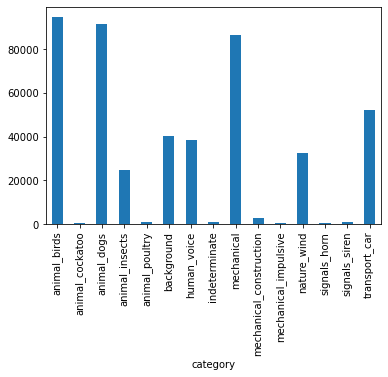

In [65]:
# show the supports for each category
tag_counts = supports(categorised, on_col='category')
print(tag_counts.to_string())
tag_counts.plot(kind='bar')

In [ ]:
# listen to snippets and view spectrograms as desired.
# filter the first argument dataframe as desired to listen to whatever specific snippets you want
# e.g. listen_to_snippets(categorised[categorised['category'] == 'dogs'], data_root, random =True, n=10)

# enter "r" to repeat playback, or "q" to quit gracefully. 
# anything else will continue to the next snippet
listen_to_snippets(categorised[(categorised['category']=='nature_rain') ], data_root, random =True)

0.2020336278239201

In [77]:
len(supports(categorised_reduced))

15

In [82]:
categorised_sample = categorised_reduced.sample(n=5000)
sampled_supports = supports(categorised_sample)


15

In [147]:
categorised_sample_one = many_to_one(categorised_sample)
categorised_sample_one
new_dest = data_root.parent/'sample_set'
new_dest.mkdir(exist_ok=True)
copy_to_new_package(categorised_sample_one, new_dest)

In [143]:
category_encoder.transform(categorised_sample_one.category_set.values).sum(axis=0)

array([2382,    6, 2229,  677,   12,  915,  964,   17, 2099,   35,    4,
        856,    7,    7, 1251])

In [138]:
category_encoder.classes_

array(['animal_birds', 'animal_cockatoo', 'animal_dogs', 'animal_insects',
       'animal_poultry', 'background', 'human_voice', 'impulsive',
       'indeterminate', 'mechanical', 'mechanical_construction',
       'mechanical_impulsive', 'nature_wind', 'signals_horn',
       'signals_siren', 'transport_car'], dtype=object)